In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

In [2]:
import numpy as np
from chainconsumer import ChainConsumer
from glob import glob
from os import path
from copy import deepcopy
from collections import OrderedDict
from os.path import basename
import emcee as mc
import h5py

In [3]:
fnames = ['/u/ki/swmclau2/des/PearceMCMC/HOD_wp_ds_rmin_0.5_HOD.hdf5']

In [4]:
f = h5py.File(fnames[0], 'r')

In [5]:
f.attrs.keys()

[u'chain_fixed_params',
 u'cov',
 u'dlogz',
 u'emu_cov_fname',
 u'emu_hps',
 u'emu_type',
 u'fixed_params',
 u'mcmc_type',
 u'nburn',
 u'nlive',
 u'nsteps',
 u'nwalkers',
 u'obs',
 u'param_names',
 u'seed',
 u'sim',
 u'training_file',
 u'true_cov_fname',
 u'true_data_fname']

In [6]:
n_walkers = f.attrs['nwalkers']

In [7]:
chain_pnames = list(f.attrs['param_names'])

In [8]:
chain_pnames.extend(['Om', 'S8']) # temporary

In [9]:
#sim_info = eval(f.attrs['sim'])
sim_info = f.attrs['sim']

In [10]:
#gal_type = eval(f.attrs['sim'])['gal_type']
if basename(fnames[0])[:3] == 'HOD' and basename(fnames[0])[4:9] != 'MDPL2':
    gal_type = 'HOD'
else:
    gal_type = 'SHAM'#'HOD'

In [11]:
f.close()

In [12]:
chain_pnames

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias',
 'Om',
 'S8']

In [13]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'sigma8': r'$\sigma_8$', 'ln10As':r'$\ln 10^{10} A_s$',
                   'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'mean_occupation_centrals_assembias_slope1': r'$\mathcal{B}_{cen}$',\
                 'mean_occupation_satellites_assembias_slope1':r'$\mathcal{B}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$',
                   'sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$',
                  'Om': r'$\Omega_m$', 'S8': r'$S_8$'}

In [14]:
bounds_dict = {'H0': (61.69472, 74.76751999999999),
    #'H0': (50., 90.),
 #'Neff': (2.62125, 4.27875),
# 'alpha': (0.7, 1.3),
# 'conc_gal_bias': (0.5, 2.0),
 'sigma8': (0.65, 1.0), # TODO update
# 'logM0': (12.6, 13.6),
# 'logM1': (13.7, 14.7),
# 'ns': (0.9278462, 0.9974495999999999),
 'ombh2': (0.02066455, 0.02371239),
 'omch2': (0.1012181, 0.13177679999999997)}
#'ombh2': (0.0, 0.05),
 #'omch2': (0.8, 0.15)}

# 'sigma_logM': (0.05, 0.5),
# 'ln10As': (3.0, 3.1),
# 'w0': (-1.399921, -0.5658486)}
 #'Om': (0.15, 0.45),
 #'S8': (0.6, 1.0),
 #'mean_occupation_centrals_assembias_corr1': (-1.0, 1.0),
 #'mean_occupation_satellites_assembias_corr1': (-1.0, 1.0),
 #'mean_occupation_centrals_assembias_param1': (-1.0, 1.0),
 #'mean_occupation_satellites_assembias_param1': (-1.0, 1.0),
 #'mean_occupation_centrals_assembias_slope1': (-3.0, 3.0),
 #'mean_occupation_satellites_assembias_slope1': (-3.0, 3.0)}

In [15]:
from itertools import izip
def lnprior(theta, param_names):
    """
    Prior for an MCMC. Default is to assume flat prior for all parameters defined by the boundaries the
    emulator is built from. Retuns negative infinity if outside bounds or NaN
    :param theta:
        The parameters proposed by the sampler.
    :param param_names
        The names identifying the values in theta, needed to extract their boundaries
    :return:
        Either 0 or -np.inf, depending if the params are allowed or not.
    """
    for p, t in izip(param_names, theta):
        low, high = bounds_dict[p]
        if p=='H0':
            h = t/100.0
        elif p == 'omch2':
            wc = t
        elif p == 'ombh2':
            wb = t
        if np.isnan(t) or t < low or t > high:
            return -np.inf
    #print 5*np.log(h),np.log(wc+wb)
    #p = 5*np.log(h)+np.log(wc+wb)
    return 0#-3*np.log(h)#0#-np.inf if np.isnan(p) else p
    #return -h**(-2)*(wc+wb)

In [16]:
def random_initial_guess(param_names, nwalkers, num_params):
    pos0 = np.zeros((nwalkers, num_params))
    for idx, pname in enumerate(param_names):
        low, high = bounds_dict[pname]
        pos0[:, idx] = np.random.randn(nwalkers) * (np.abs(high - low) / 3.0) +\
        (low + high) / 2.0
        # TODO variable with of the initial guess
        
    prior = np.array([lnprior(p, param_names) for p in pos0])
    #pos0[~np.isfinite(prior)] = (low+high)/2.0+np.random.randn()*1e-3

    return pos0

In [17]:
param_names = bounds_dict.keys()
nwalkers = 250
num_params = len(bounds_dict)
nburn=10000#*nwalkers
nsteps = 60000

In [18]:


sampler = mc.EnsembleSampler(nwalkers, num_params, lnprior,
                             threads=4, args=((param_names,)))

pos0 = random_initial_guess(param_names, nwalkers, num_params)

In [19]:
sampler.run_mcmc(pos0, nsteps);

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [20]:
chain = sampler.chain[:, nburn:, :].reshape((-1, num_params))

In [21]:
def modify_chain(chain, param_names):
    new_pnames = ['Om', 'S8']
    h = chain[:,param_names.index('H0')]/100
    ih2 = 1/(h**2)
    Omc, Omb = chain[:,param_names.index('omch2')]/(h**2), chain[:,param_names.index('ombh2')]/(h**2)
    Om = Omc+Omb
    #print np.sum(chain[:,param_names.index('omch2')]<0)
    #print np.sum(Omc<0)
    #print np.sum(Omb<0)
    #print np.sum(Om<0)
    S8 = chain[:,param_names.index('sigma8')]*np.sqrt(Om/0.3)

    new_chain = np.hstack([chain[:,:7], ih2.reshape((-1,1)), Om.reshape((-1,1)), S8.reshape((-1,1)), chain[:,7:]])
    param_names.insert(7, 'iH2')
    param_names.insert(8, new_pnames[0])
    param_names.insert(9, new_pnames[1])

    return new_chain, param_names

In [22]:
chain, param_names = modify_chain(chain, param_names)

In [23]:
chain.shape

(12500000, 7)

In [24]:
c = ChainConsumer()
param_name_dict['iH2'] = r'$1/(h^2)$'
plot_param_names = [param_name_dict[p] for p in param_names]
bounds_dict['iH2'] = ((100.0/bounds_dict['H0'][1])**2,(100.0/bounds_dict['H0'][0])**2)
bounds_dict['Om'] = (0.225, 0.4)
bounds_dict['S8'] = (0.6, 1.1)

plot_bounds = [bounds_dict[p] for p in param_names]
c.add_chain(chain, parameters=plot_param_names, walkers = n_walkers)

In [25]:
#c.configure(colors = [color_to_hex(p) for p in palette], shade = True, shade_alpha=0.2, shade_gradient=1.0)
c.configure(diagonal_tick_labels=False, tick_font_size=8, label_font_size=25, \
            max_ticks=8, summary=False)#, statistics='cumulative')

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


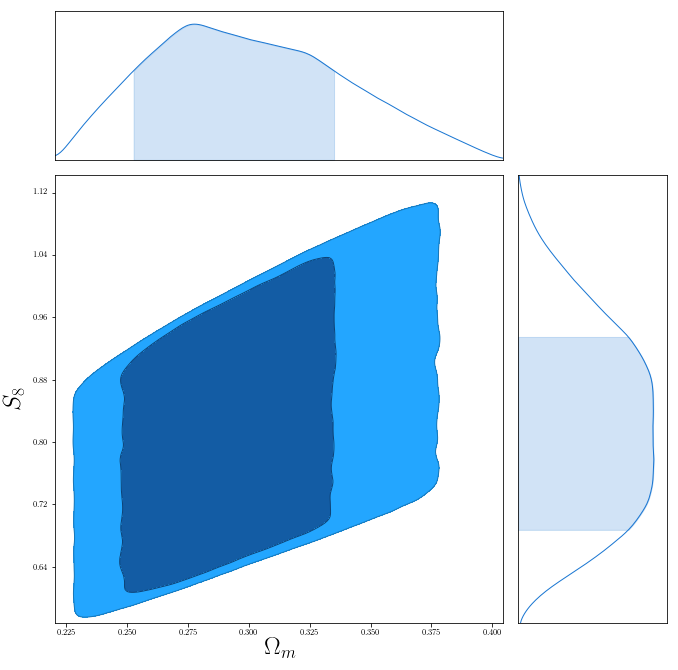

In [28]:
fig = c.plotter.plot(figsize='PAGE', parameters=[r'$\Omega_m$',r'$S_8$'],
                    )
fig.patch.set_facecolor('white')

fig.show()
plt.savefig('mcmc_prior.pdf', format='pdf', bbox_inches ='tight')

In [28]:
#h = np.random.rand(10000)*15+62
#h = np.random.rand(10000)*70+33
h0, h1 = 0.6, 0.8
h0m2, h1m2 = 1/(h0**2), 1/(h1**2)
hm2 = np.random.rand(10000)*(h1m2-h0m2) + h0m2
h = 100*(1/np.sqrt(hm2))
omch2 = np.random.rand(10000)*0.04+0.1
sigma8 = np.random.rand(10000)*0.4+0.6
om = omch2/((h/100)**2)
s8 = sigma8*np.sqrt(om/0.3)

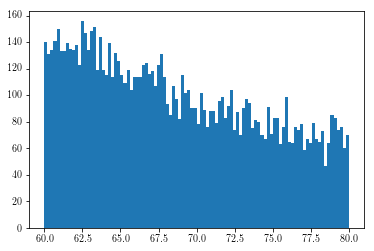

In [29]:
plt.hist(h, bins = 100);

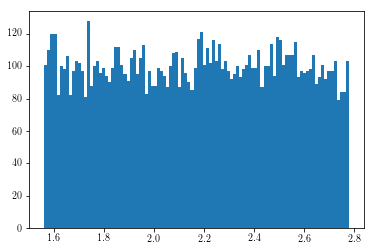

In [30]:
plt.hist((h/100)**(-2), bins = 100);

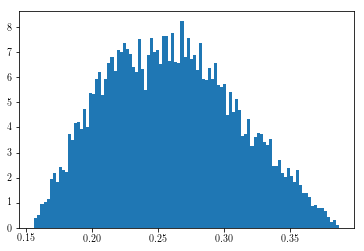

In [31]:
plt.hist(om, bins = 100, normed = True);

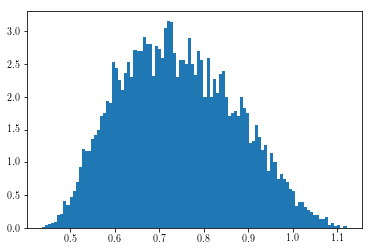

In [32]:
plt.hist(s8, bins = 100, normed=True);

In [33]:
fig = c.plotter.plot(figsize='PAGE', parameters = cosmo_param_names, truth=cosmo_true_vals, extents=cosmo_bounds) 
fig.show()

NameError: name 'cosmo_param_names' is not defined

In [ ]:
from copy import deepcopy
true_vals  = list(deepcopy(cosmo_true_vals))
true_vals.extend(plot_hod_true_vals)

In [ ]:
plot_param_names = list(deepcopy(cosmo_param_names))
plot_param_names.extend(plot_hod_param_names)

In [ ]:
plot_param_bounds = list(deepcopy(cosmo_bounds))
plot_param_bounds.extend(plot_hod_bounds)

In [ ]:
plot_param_names

In [ ]:
# TODO can choose these by galaxy model 
# TODO combine multiple chains? 
#summary_idxs = [1, 4]
summary_idxs = [7,6,8,4,13]
#summary_idxs = [7, 8,4]#,13]
if len(plot_param_names) > 14:
    #summary_idxs.extend([14,15])#,18,19])
    #summary_idxs.extend([11,12])
    pass


summary_pnames = [plot_param_names[i] for i in summary_idxs]
summary_truths = [true_vals[i] for i in summary_idxs]
summary_bounds = [plot_param_bounds[i] for i in summary_idxs]

In [ ]:
fig = c.plotter.plot(figsize='PAGE', parameters =summary_pnames\
                                    , truth=summary_truths, extents=summary_bounds) 
fig.patch.set_facecolor('white')
fig.show()

In [ ]:
fig = c.plotter.plot(figsize='PAGE', truth=true_vals) 
fig.patch.set_facecolor('white')
fig.show()

In [ ]:
for pname in summary_pnames:
    print pname,'\t',
print
print '*'*20

for MAP in MAPs:
    for pname in summary_pnames:
        print MAP[pname],'\t',
    print 
print '*'*20
for st in summary_truths:
    print '%.4f'%st,'\t'*2,

In [ ]:
MAP = [MAPs[0][pname] for pname in summary_pnames]

In [ ]:
fig = c.plotter.plot(chains =[r"$r_{min} = %s$"%str(5.0)], figsize='PAGE', parameters =summary_pnames\
                                    , truth=summary_truths)#, extents=summary_bounds) 
fig.show()

In [ ]:
c.configure(bar_shade=True)

In [ ]:
fig = c.plotter.plot_summary(parameters=summary_pnames, truth=summary_truths,\
                             extents=summary_bounds,\
                             figsize=2, errorbar=False) 
#fig.suptitle(model) # + galtype
fig.show()